# Optimisation de portefeuille vs portefeuille permanent 

## 1. Cadre général de la comparaison 

L’objectif de cette étude est de comparer deux approches fondamentalement opposées de la construction de portefeuille :
* le portefeuille permanent avec une allocation fixe, simple et robuste. 
* le portefeuille optimisé avec une allocation issu d’un cadre théorique d’optimisation quantitative basé sur les données historiques.

L’enjeu n’est pas seulement de comparer des performances brutes mais d’évaluer si une optimisation d'allocation, supposée améliorer le couple rendement/risque, surperforme réellement une allocation fixe mais bien diversifiée dans un cadre empirique réaliste.

La problématique :
L’optimisation de portefeuille permet-elle d’obtenir un gain économique significatif par rapport à un portefeuille permanent ?

Cette comparaison illustre deux concepts à la fois :
* l'efficacité théorique des modèles d’optimisation (Markowitz)
* la robustesse des règles simples (diversification et allocation fixe)

Afin d’assurer une comparaison équitable, les deux portefeuilles reposent strictement sur le même univers d’investissement et sont évalués sur les mêmes périodes. 

## 2. Description des portefeuilles comparés

### 2.1 Portefeuille permanent 

Le portefeuille permanent repose sur l’idée qu’il est impossible de prévoir les régimes macroéconomiques, et qu’un portefeuille bien diversifié doit être capable de résister à différents environnements économiques (Harry Browne). 

Le portefeuille permanent vise une performance stable à long terme en répartissant le capital entre des actifs réagissant différemment aux grands cycles économiques :
* croissance
* récession
* inflation
* déflation

Il ne cherche pas à maximiser un rendement espéré mais à minimiser le risque de scénarios extrêmes.

Composition : 
* Actions : moteur de croissance à long terme
* Obligations long terme : protection en période de récession et de baisse des taux
* Or : couverture contre l’inflation et les crises systémiques
* Cash / monétaire : stabilité et optionnalité

Les pondérations sont fixes et exogènes :
* 25 % par classe d’actifs



{'Annualized returns': '4.58 %', 'Annualized_risk': '7.13 %'}


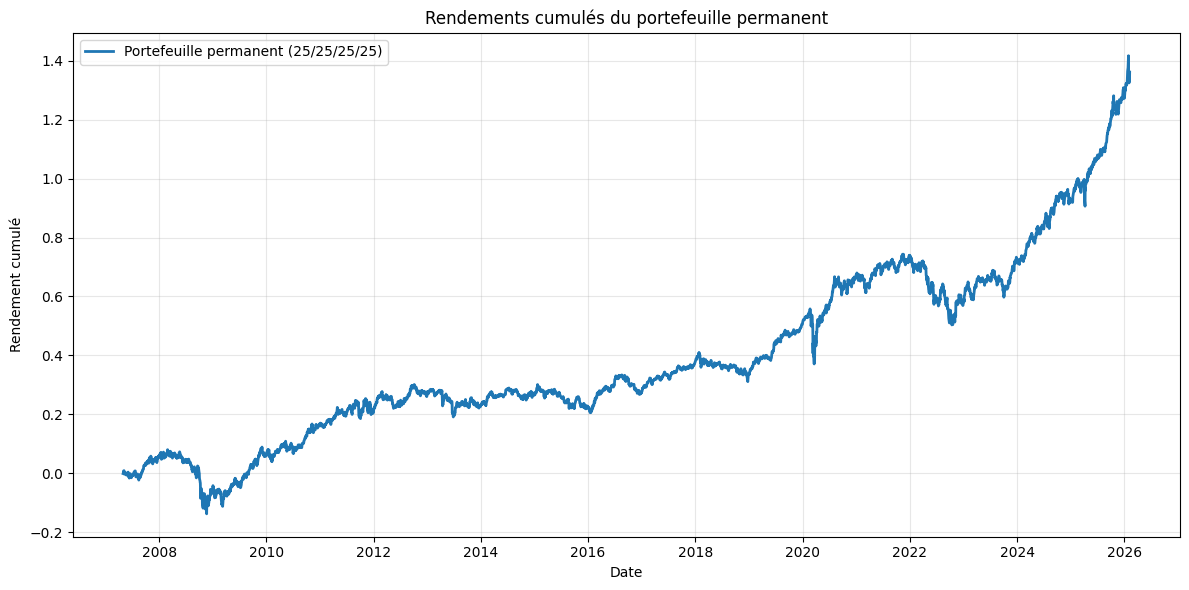

In [25]:
# Importation des packages 

import pandas as pd
import numpy as np 
from pypfopt import expected_returns, efficient_frontier, plotting, risk_models
from matplotlib import pyplot as plt
from scipy.stats import norm

# Importation des données 

excel = "data_pp.xlsx"

df = pd.read_excel(excel,
                   parse_dates=True,
                   index_col=0,
                   header=0
                   )

# Définition des poids du portefeuille permanent (pp)

n = len(df.columns)
weights_pp = np.array([round(1/n,6)] * n )

# Caclul des rendements des actifs et du pp

log_returns = np.log(df/df.shift(1))     
log_returns = log_returns.dropna()   

expected_returns_pp = np.dot(log_returns.mean(), weights_pp)  
expected_returns_annualized = expected_returns_pp * 252 

# Calcul du risque du pp 

cov_matrix_log = log_returns.cov()  
variance = weights_pp.T @ cov_matrix_log @ weights_pp
risk_pp = np.sqrt(variance)

risk_pp_annualized = risk_pp * np.sqrt(252)

# Rendement et risque annualisé

risk_returns_pp = {
    "Annualized returns" : f'{round(expected_returns_annualized*100,2)} %',
    "Annualized_risk" : f'{round(risk_pp_annualized*100,2)} %'
}
print(risk_returns_pp)

# Représentation graphique du portefeuille permanent sur la période 

pp_log_returns = log_returns @ weights_pp
cum_pp = np.exp(pp_log_returns.cumsum()) - 1

# 5) Graphique

plt.figure(figsize=(12, 6))
plt.plot(
    cum_pp.index,
    cum_pp,
    label="Portefeuille permanent (25/25/25/25)",
    linewidth=2
)
plt.title("Rendements cumulés du portefeuille permanent")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Premier résultat, un portefeuille permanent composé d'action, d'obligation, de l'or et du cash sur une période de 20 ans avec une allocation équipondérée à 25% génère une estimation de rendement annualisé de 4.58% pour un risque estimé annualisé de 7.13%. 

### 2.2 Portefeuille optimisé 

Le portefeuille optimisé repose sur une logique inverse :
les pondérations sont endogènes, déterminées par une procédure d’optimisation quantitative à partir des données historiques.

Afin d’assurer une comparaison équitable, le portefeuille optimisé utilise exactement les mêmes classes d’actifs que le portefeuille permanent :
* actions
* obligations
* or
* cash / monétaire

La différence entre les deux portefeuilles ne provient que des pondérations, et non du choix des actifs.

Les podérations du portefeuille optimisé :
* peuvent varier dans le temps 
* dépendent de la fenêtre d'estimation utilisée 

## 3. Méthodologie d'optimisation 

### 3.1 Choix du modèle d'optimisation 

Le portefeuille optimisé est construit dans le cadre de la théorie moyenne–variance de Markowitz.
L’objectif est de déterminer le vecteur de pondérations w qui optimise le compromis entre rendement et risque, mesuré par la variance du portefeuille.

Deux formulations classiques peuvent être retenues :
* Minimum Variance Portfolio
* Maximum Sharpe Ratio Portfolio

Dans le cadre de la comparaison avec un portefeuille permanent, le maximum sharpe ratio est plus pertinent car le portefeuille permanent est déjà orienté vers la stabilité et rendement minimal donc cela limite l’impact des erreurs d’estimation des rendements

### 3.2 Estimation des paramètres 

Les rendements espérés sont estimés à partir de la moyenne historique des rendements sur la période d’estimation.
Cette approche est volontairement retenue afin de :
* rester cohérent avec une approche empirique standard
* éviter l’introduction de biais subjectifs

In [26]:
mu_po = expected_returns.mean_historical_return(prices = df,log_returns=True)

La matrice de covariance est un élément central de l’optimisation. Elle est estimée à partir des rendements historiques et peut être :
* empirique (covariance classique)
* améliorée via une méthode de shrinkage (optionnel)

Choix de la méthode de shrinkage

In [27]:
s_po = risk_models.CovarianceShrinkage(prices=df,log_returns=True).ledoit_wolf()

### 3.3 Contraintes d'optimisation 

Afin de garantir la faisabilité économique du portefeuille, les contraintes suivantes sont imposées :
* Long-only : pas de vente à découvert
* Somme des pondérations = 1
* Bornes sur les poids (ex : 0 % – 40 % par classe d’actifs)

Ces contraintes permettent :
* d’éviter des allocations extrêmes
* de rapprocher l’optimisation d’un cadre institutionnel réaliste
* de rendre la comparaison avec le portefeuille permanent économiquement pertinente


/var/folders/6n/7h7w4psx61nd8v1xm42bnz8m0000gn/T/ipykernel_43536/3547891777.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(stds, rets, marker=".", cmap="viridis_r")


OrderedDict({'bonds': 0.0, 'stock': 0.2227098816708036, 'gold': 0.4, 'cash': 0.3772901183291964})
0.050227603107851106 0.08581592291987598


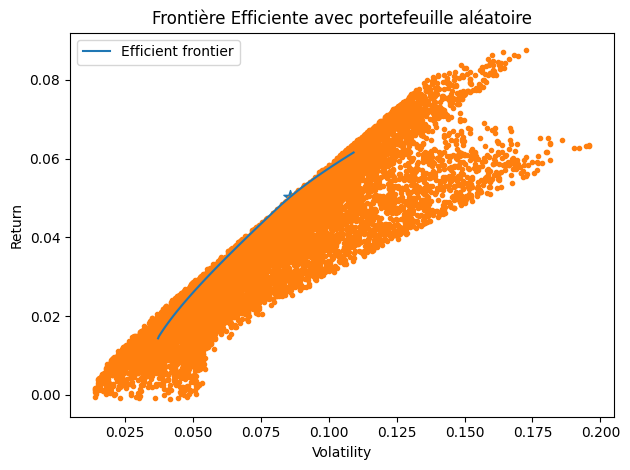

In [28]:
ef = efficient_frontier.EfficientFrontier(mu_po,s_po, weight_bounds=(0.0,0.40))

fig, ax = plt.subplots()
ef_min_vol = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
weights_po = ef_min_vol.max_sharpe()
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
ax.scatter(stds, rets, marker=".", cmap="viridis_r")

# Output
ax.set_title("Frontière Efficiente avec portefeuille aléatoire")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)

print(weights_po)
print(ret_tangent,std_tangent)





Les résultats de l'optimisation montrent qu'avec une allocation optimisée comme suit : 
* 0.00 % d'obligations 
* 22.27 % d'actions 
* 40 % d'or 
* 37.73 % de cash 

Le portefeuille optimisé donne une estimation du rendement annualisé à    5.02% pour un risque annualisé à 8.58%

Représentation graphique du portefeuille optimisé sur la période :

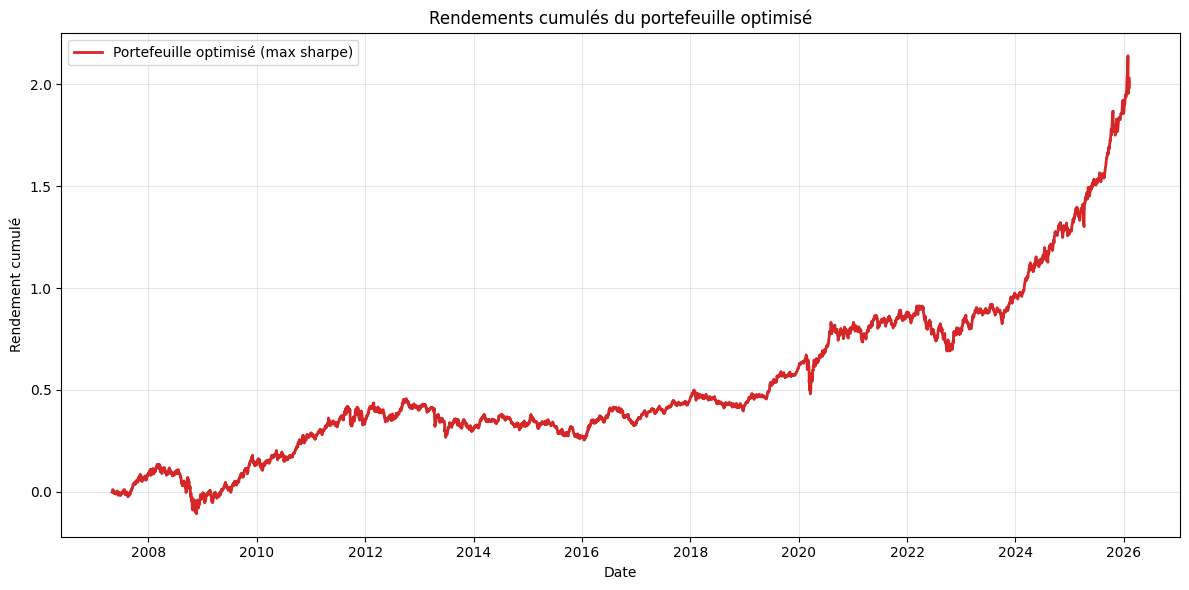

In [29]:
weights_opt = np.array([0.0, 0.2227098816708036, 0.4, 0.3772901183291964])
opt_log_returns = log_returns @ weights_opt

# 4) Rendements cumulés
cum_opt = np.exp(opt_log_returns.cumsum()) - 1

# 5) Graphique
plt.figure(figsize=(12, 6))
plt.plot(
    cum_opt.index,
    cum_opt,
    label="Portefeuille optimisé (max sharpe)",
    linewidth=2,
    color="#d62728"
)
plt.title("Rendements cumulés du portefeuille optimisé")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Comparaison graphique des deux portefeuilles 

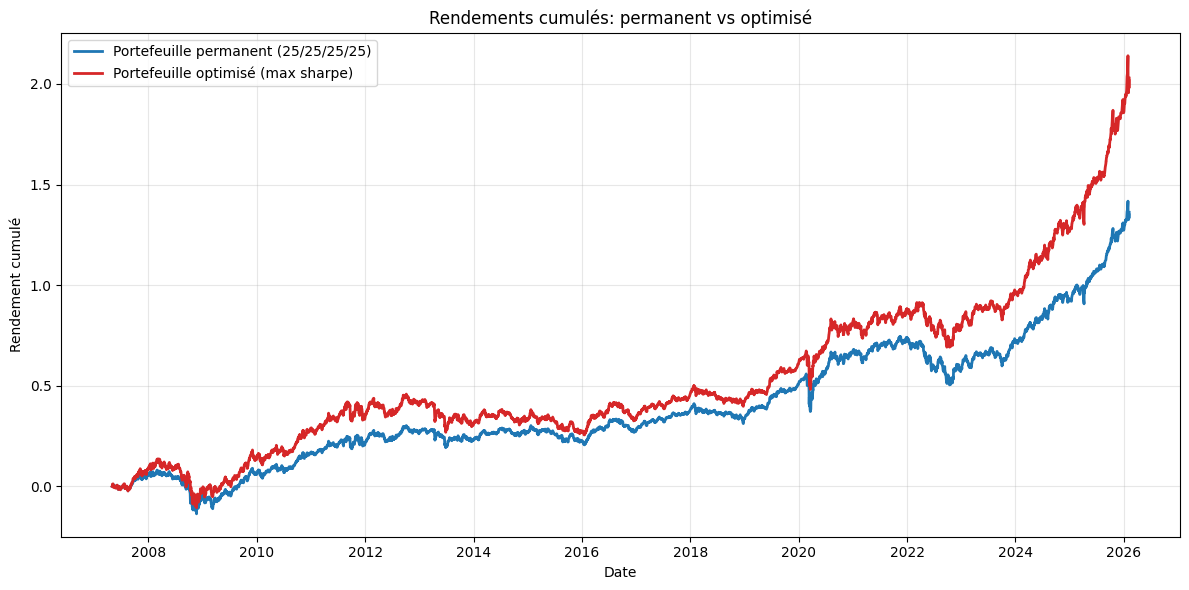

In [30]:
# 5) Les deux ensemble sur le même graphe
plt.figure(figsize=(12, 6))
plt.plot(cum_pp.index, cum_pp, label="Portefeuille permanent (25/25/25/25)", linewidth=2)
plt.plot(cum_opt.index, cum_opt, label="Portefeuille optimisé (max sharpe)", linewidth=2, color = "#d62728")
plt.title("Rendements cumulés: permanent vs optimisé")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Le graphique des rendements cumulés montre une opposition claire entre performance et stabilité :

* Le portefeuille optimisé est plus performant mais plus risqué que le portefeuille permanent sur la période étudié.
* Le portefeuille permanent est plus lisse (moins volatil) mais sa croissance est faiblement moindre que celle du portefeuille optimisé. 

## 4. Analyse de Robustesse 

Dans un premier temps, nous avons introduit deux contraintes à notre simulation : une première qui consiste à constituer deux portefeuilles avec une contrainte de minimisation de la variance, où nous avons obtenu les résultats suivants : 1,435 % pour un risque de 3,72 %. 

Cela se traduit par le phénomène de la sécurité à tout prix : l’algorithme minimum variance a cherché mathématiquement la combinaison la moins risquée. 

Il a probablement surpondéré le cash et les obligations qui bougent peu à court terme. Tout simplement, il a tué le rendement pour sauver la volatilité. On en déduit donc que le portefeuille permanent l’écrase car il a un ratio de Sharpe de 0,64 contre 0,34 pour le portefeuille optimisé. 

En l’occurrence, le test de stress est utile uniquement pour chercher un krach violent comme une remontée des taux, mais la crise de 2008 n’aurait pas eu un impact significatif sur le portefeuille car il est rempli d’obligations et de cash.

Ensuite, nous sommes passés d’une stratégie défensive à une stratégie offensive, Max Sharpe. Nous avons donc trouvé un rendement de 5,12 % pour un risque de 8,58 %. Le ratio de Sharpe pour le permanent est de 0,64 et pour le portefeuille optimisé de 0,60.

Donc l’algorithme mathématique complexe qui était censé trouver le meilleur portefeuille a fini par produire un portefeuille moins performant que le permanent, soit à cause de l’instabilité des corrélations, soit à cause des coûts du risque.

La VaR est donc l’outil indispensable quand le ratio de Sharpe est décevant.

Le ratio de Sharpe nous dit si on est rentable par rapport à notre risque, c’est une mesure de performance, tandis que la VaR nous dit si on va survivre à une mauvaise journée, mesure de sécurité.

La VaR va venir capturer ce que la volatilité cache. Si la distribution était parfaitement normale, la VaR est proportionnelle à la volatilité, mais si le max Sharpe a du kurtosis, sa VaR sera bien pire que ce que sa volatilité laisse présager.

### 4.1 VaR des portefeuilles


In [31]:

# Rendement des portefeuilles 
portfolio_rets_pp = pp_log_returns
portfolio_rets_po = opt_log_returns 

conf_level = 0.95
alpha = 1 - conf_level # 0.05

# Méthode 1: VaR Paramétrique
z_score = norm.ppf(alpha)

var_param_pp = -(portfolio_rets_pp.mean() + z_score * portfolio_rets_pp.std())
var_param_po = -(portfolio_rets_po.mean() + z_score * portfolio_rets_po.std())

# Méthode 2: VaR Historique
var_hist_pp = -np.percentile(portfolio_rets_pp, alpha * 100)
var_hist_po = -np.percentile(portfolio_rets_po, alpha * 100)

#5. Affichage des Résultats
print(f"--- Résultats VaR (Niveau de confiance : {conf_level*100}%) ---")
print("\n1. Portefeuille Permanent (Equipondéré) :")
print(f"   - VaR Paramétrique : {var_param_pp:.4%}")
print(f"   - VaR Historique   : {var_hist_pp:.4%}")

print("\n2. Portefeuille Optimisé (Max sharp) :")
print(f"   - VaR Paramétrique : {var_param_po:.4%}")
print(f"   - VaR Historique   : {var_hist_po:.4%}")

# Interprétation rapide
print("\n--- Interprétation ---")
print(f"Une VaR de {var_hist_po:.2%} signifie qu'il y a 95% de chances que votre perte journalière ne dépasse pas {var_hist_po:.2%}.")

--- Résultats VaR (Niveau de confiance : 95.0%) ---

1. Portefeuille Permanent (Equipondéré) :
   - VaR Paramétrique : 0.7211%
   - VaR Historique   : 0.6682%

2. Portefeuille Optimisé (Max sharp) :
   - VaR Paramétrique : 0.8662%
   - VaR Historique   : 0.8208%

--- Interprétation ---
Une VaR de 0.82% signifie qu'il y a 95% de chances que votre perte journalière ne dépasse pas 0.82%.


1. Portefeuille Permanent (Equipondéré) :
   
* VaR Historique   : 0.6682%

2. Portefeuille Optimisé (Max sharp) :
   
* VaR Historique   : 0.8208%

--- Interprétation ---

Une VaR de 0,82 % signifie qu’il y a 95 % de chances que votre perte journalière ne dépasse pas 0,82 %. Nous avons donc constaté une défaite du portefeuille optimisé face au portefeuille permanent. Au final, la complexité ne paie pas.

Il est plus dangereux car sa VaR est 22 % plus élevée pour gagner un tout petit peu plus de rendement, et il est moins efficient car son ratio de Sharpe est plus bas, ce qui signifie que le surplus de risque pris est mal rémunéré.

Donc, dans la partie test de stress, on va chercher à nuancer cette défaite.

### 4.2 Test de Stress sur les portefeuilles 


 RÉSULTATS DES STRESS TESTS (Crises Historiques)
               Scénario Permanent (Perf) Optimisé (Perf) Différence
Crise Financière (2008)           -9.19%          -8.37%      0.82%
  Crash COVID-19 (2020)          -10.77%          -9.79%      0.97%
  Choc Inflation (2022)          -13.61%         -10.21%      3.40%


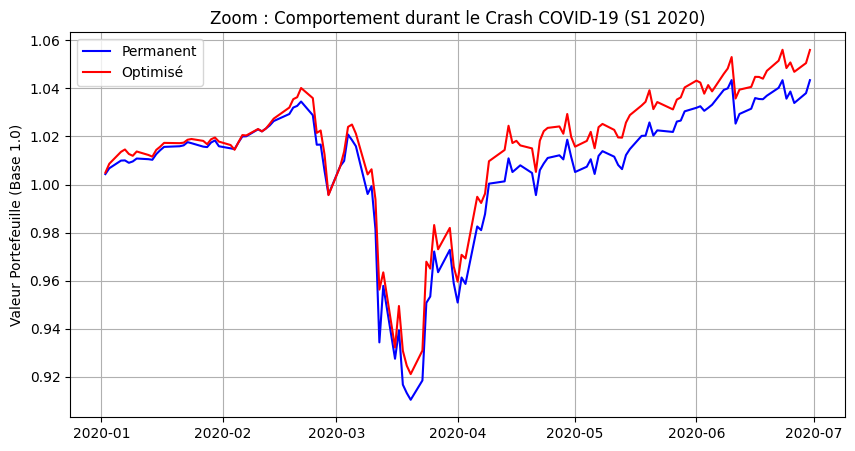

In [34]:
# --- 1. Configuration des Périodes de Crise ---
# On définit les dates exactes des crashs majeurs
crises = {
    "Crise Financière (2008)": ('2008-09-01', '2008-11-30'), # Faillite Lehman
    "Crash COVID-19 (2020)":   ('2020-02-19', '2020-03-23'), # Confinement mondial
    "Choc Inflation (2022)":   ('2022-01-01', '2022-10-14')  # Remontée des taux
}

# --- 2. Fonction de Stress Test ---
def run_stress_test(returns_pp, returns_po, crisis_dict):
    results = []

    print("\n" + "="*60)
    print(" RÉSULTATS DES STRESS TESTS (Crises Historiques)")
    print("="*60)

    for crisis_name, (start_date, end_date) in crisis_dict.items():
        # On vérifie si les dates existent dans vos données
        # (On convertit en datetime pour être sûr)
        s_date = pd.to_datetime(start_date)
        e_date = pd.to_datetime(end_date)

        # On extrait la sous-période
        # On utilise le DataFrame original log_returns pour filtrer par index
        try:
            sub_pp = returns_pp.loc[s_date:e_date]
            sub_po = returns_po.loc[s_date:e_date]

            if not sub_pp.empty:
                # Performance cumulée sur la période : (Somme des log returns -> exp) - 1
                perf_pp = np.exp(sub_pp.sum()) - 1
                perf_po = np.exp(sub_po.sum()) - 1

                # Max Drawdown durant la crise (Pire baisse du sommet au creux)
                # Calcul rapide approximatif pour la période
                dd_pp = (np.exp(sub_pp.cumsum()) - np.exp(sub_pp.cumsum().cummax())).min()
                dd_po = (np.exp(sub_po.cumsum()) - np.exp(sub_po.cumsum().cummax())).min()

                results.append({
                    "Scénario": crisis_name,
                    "Permanent (Perf)": f"{perf_pp:.2%}",
                    "Optimisé (Perf)": f"{perf_po:.2%}",
                    "Différence": f"{perf_po - perf_pp:.2%}"
                })
            else:
                results.append({"Scénario": crisis_name, "Note": "Pas de données"})

        except KeyError:
             results.append({"Scénario": crisis_name, "Note": "Dates hors limites"})

    # Affichage propre
    res_df = pd.DataFrame(results)
    if not res_df.empty and "Permanent (Perf)" in res_df.columns:
        print(res_df.to_string(index=False))
    else:
        print("Aucune période de crise correspondante trouvée dans vos données.")
    print("="*60)


rets_pp = portfolio_rets_pp
rets_po = portfolio_rets_po

run_stress_test(rets_pp, rets_po, crises)

# --- 4. Graphique Zoom sur le Covid (2020) ---
# Si les données 2020 existent, on les trace
start_2020 = '2020-01-01'
end_2020 = '2020-06-30'

if pd.to_datetime(start_2020) in rets_pp.index or pd.to_datetime(end_2020) in rets_pp.index:
    zoom_pp = rets_pp.loc[start_2020:end_2020].cumsum()
    zoom_po = rets_po.loc[start_2020:end_2020].cumsum()

    plt.figure(figsize=(10, 5))
    plt.plot(np.exp(zoom_pp), label="Permanent", color="blue")
    plt.plot(np.exp(zoom_po), label="Optimisé", color="red")
    plt.title("Zoom : Comportement durant le Crash COVID-19 (S1 2020)")
    plt.ylabel("Valeur Portefeuille (Base 1.0)")
    plt.legend()
    plt.grid(True)
    plt.show()

Surprise : si la VaR et le ratio de Sharpe disent que le portefeuille optimisé est nul mais que le stress test dit que c'est bon = paradoxe financier.

Cela signifie que notre portefeuille a un profil assurance. Au quotidien, le portefeuille bouge beaucoup, c’est pour ça qu’il a une VaR et un Sharpe qui ne sont pas bons. En revanche, pendant les crises, il ne suit pas le choc, au contraire, il l’amortit mieux que le permanent.

Donc si l’optimisé bat le permanent, c’est que sûrement il doit être surchargé de valeurs refuges (or ou cash), avec peu d’exposition aux actions, contrairement au permanent qui, lui, est à 25 % de pondération sur chaque classe d’actifs. Et pendant la crise de 2008, les actions ont perdu moins de 50 %, donc un coup mathématiquement inévitable.

Le test de stress est excellent car, tout simplement, l’algo a été visionnaire et a tué les obligations, car en 2022 les obligations ont pris un coup avec le choc inflationniste et l’augmentation des taux. Elles ont baissé considérablement, donc le permanent, avec ses 25 % d’obligations, a pris ce choc, alors que le portefeuille optimisé l’a esquivé.

Et il a blindé l’or, qui est considéré comme étant l’actif antifragile car en 2008, 2020 et 2022, il a joué le rôle de valeur refuge. Donc avoir 40 % d’or et 38 % de cash signifie que 78 % du portefeuille est immunisé contre la faillite bancaire ou d’entreprise.